In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import  norm
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
df = pd.read_csv('dataset/mobile_addiction_data_processed.csv')


0       1
1       1
2       1
3       1
4       1
       ..
2981    1
2982    1
2983    1
2984    1
2985    1
Name: Anomali, Length: 2986, dtype: int64


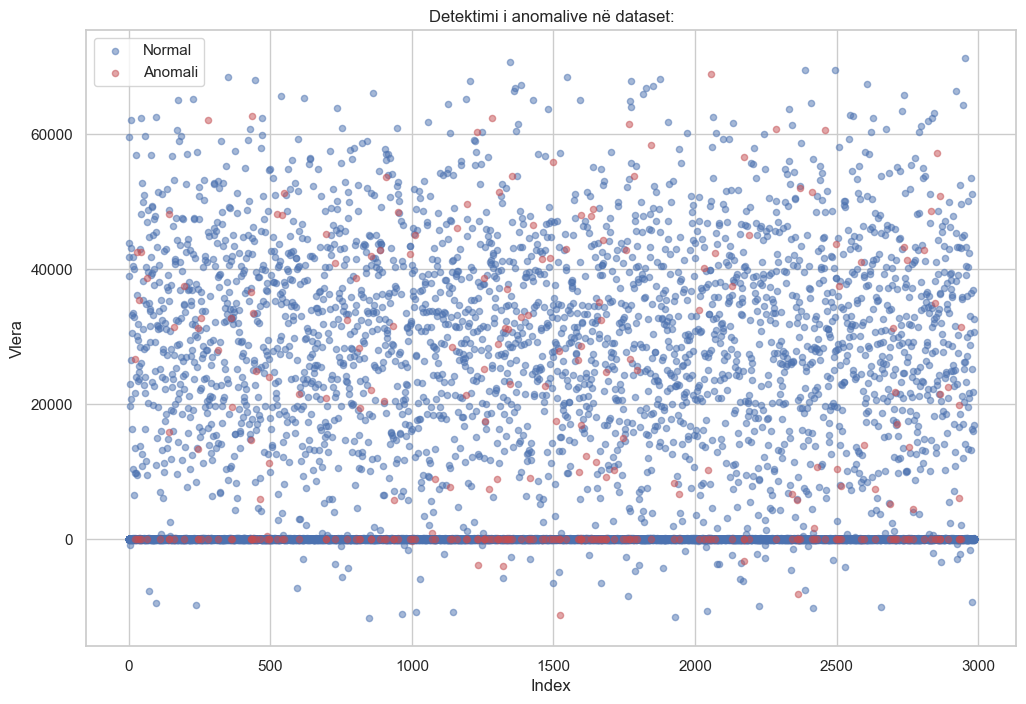

In [55]:
# Zgjidhen vetëm kolonat numerike nga dataseti
from sklearn.ensemble import IsolationForest


numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_data = df[numeric_columns]

# Inicializimi i Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomali'] = iso_forest.fit_predict(numeric_data)
print(df['Anomali'])
# Ndarja e anomalive dhe i të dhënave normale për vizualizim
normal_data = df[df['Anomali'] == 1]
anomalies = df[df['Anomali'] == -1]

sns.set_theme(style='whitegrid')

# # Vizualizimi i Pair Plot
# plt.figure(figsize=(12, 8))
# sns.pairplot(df, hue='Anomali', palette={1: 'blue', -1: 'red'}, diag_kind='kde', markers=["o", "s"])
# plt.suptitle('Pair Plot per detektimin e anomalive', y=1.02)
# plt.show()

# Vizualizimi shtesë i scatter plot për secilën kolone
plt.figure(figsize=(12, 8))
for col in numeric_columns:
    plt.scatter(normal_data.index, normal_data[col], label='Normal', color='b', alpha=0.5, s=20)
    plt.scatter(anomalies.index, anomalies[col], label='Anomali', color='r', alpha=0.5, s=20)

plt.legend(['Normal', 'Anomali'])
plt.title('Detektimi i anomalive në dataset:')
plt.xlabel('Index')
plt.ylabel('Vlera')
plt.show()

#DBSCAN

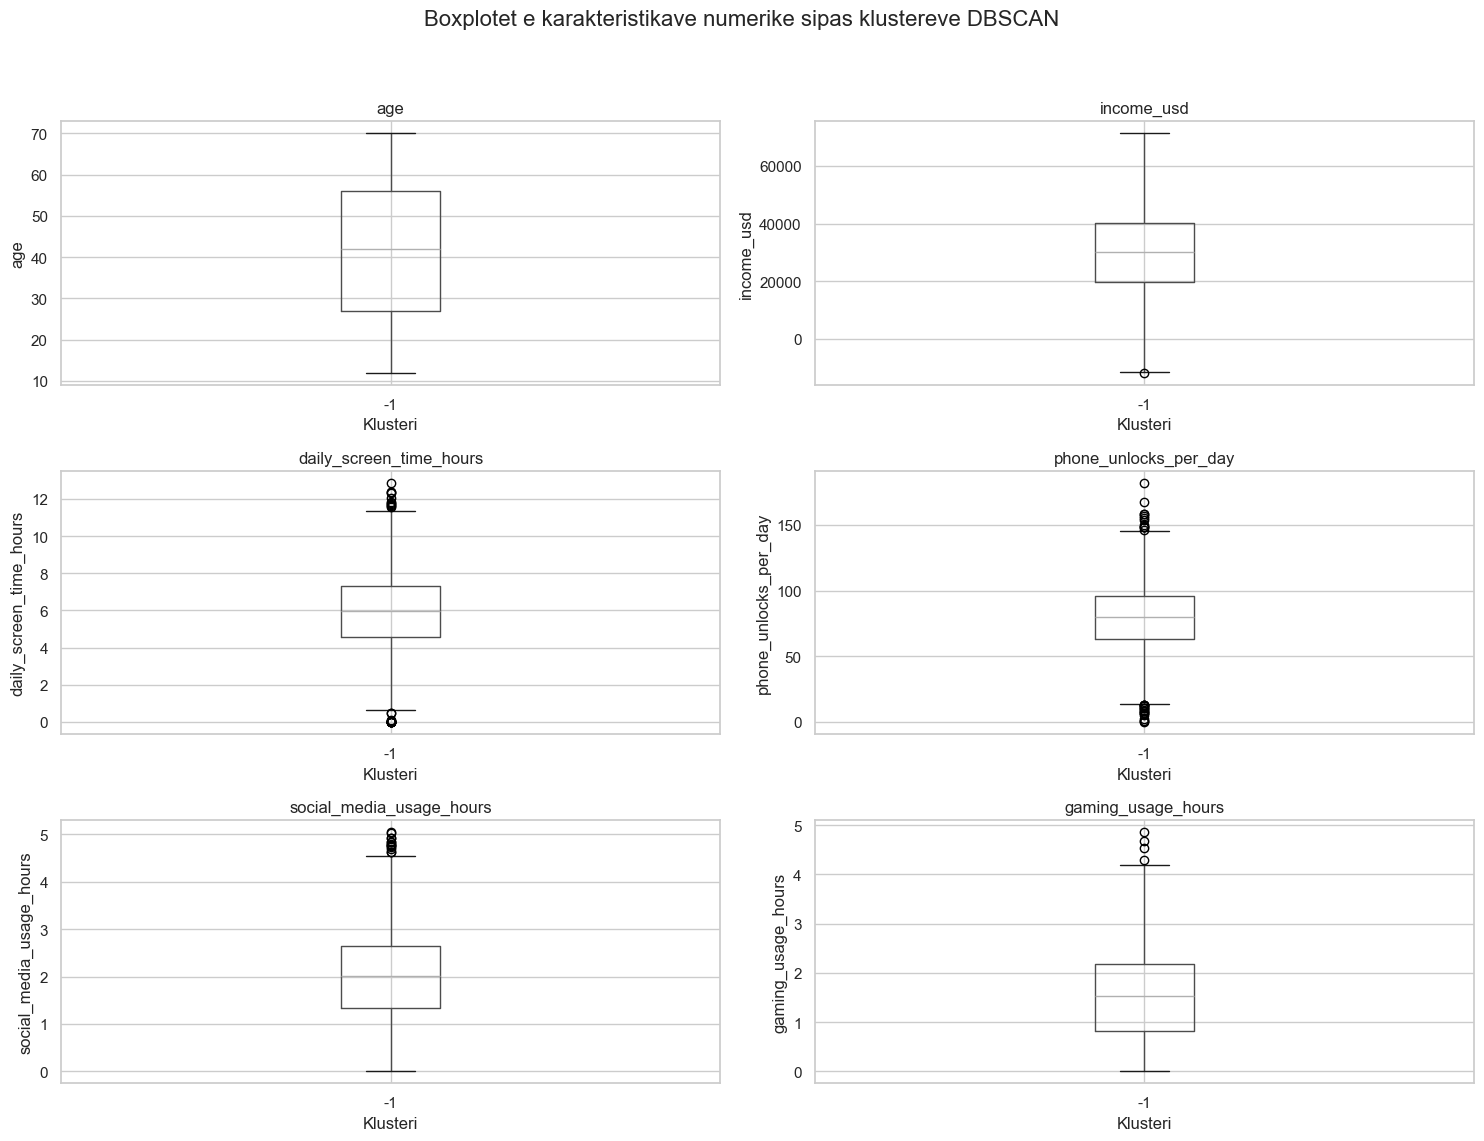

In [33]:
from sklearn.cluster import DBSCAN

numerical_columns = [
    'age',
    'income_usd',
    'daily_screen_time_hours',
    'phone_unlocks_per_day',
    'social_media_usage_hours',
    'gaming_usage_hours',
    'streaming_usage_hours',
    'messaging_usage_hours',
    'work_related_usage_hours',
    'sleep_hours',
    'physical_activity_hours',
    'mental_health_score',
    'depression_score',
    'anxiety_score',
    'stress_level',
    'time_spent_with_family_hours',
    'online_shopping_hours',
    'monthly_data_usage_gb',
    'age_first_phone',
    'push_notifications_per_day',
    'tech_savviness_score',
    'relationship_status_encoded',
    'urban_or_rural_encoded',
    'self_reported_addiction_level_encoded',
    'gender_encoded',
    'Total_Entertainment_Hours',
    'Overall_Mental_Health_Index'
]


data_numerical = df[numerical_columns]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numerical)

dbscan = DBSCAN(eps=0.5, min_samples=5)

clusters = dbscan.fit_predict(data_scaled)

df['Cluster'] = clusters

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

for ax, column in zip(axes.flatten(), numerical_columns):
    df.boxplot(column=column, by='Cluster', ax=ax)
    ax.get_figure().suptitle('Boxplotet e karakteristikave numerike sipas klustereve DBSCAN', fontsize=16)
    ax.set_title(column)
    ax.set_xlabel('Klusteri')
    ax.set_ylabel(column)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

KMeans 

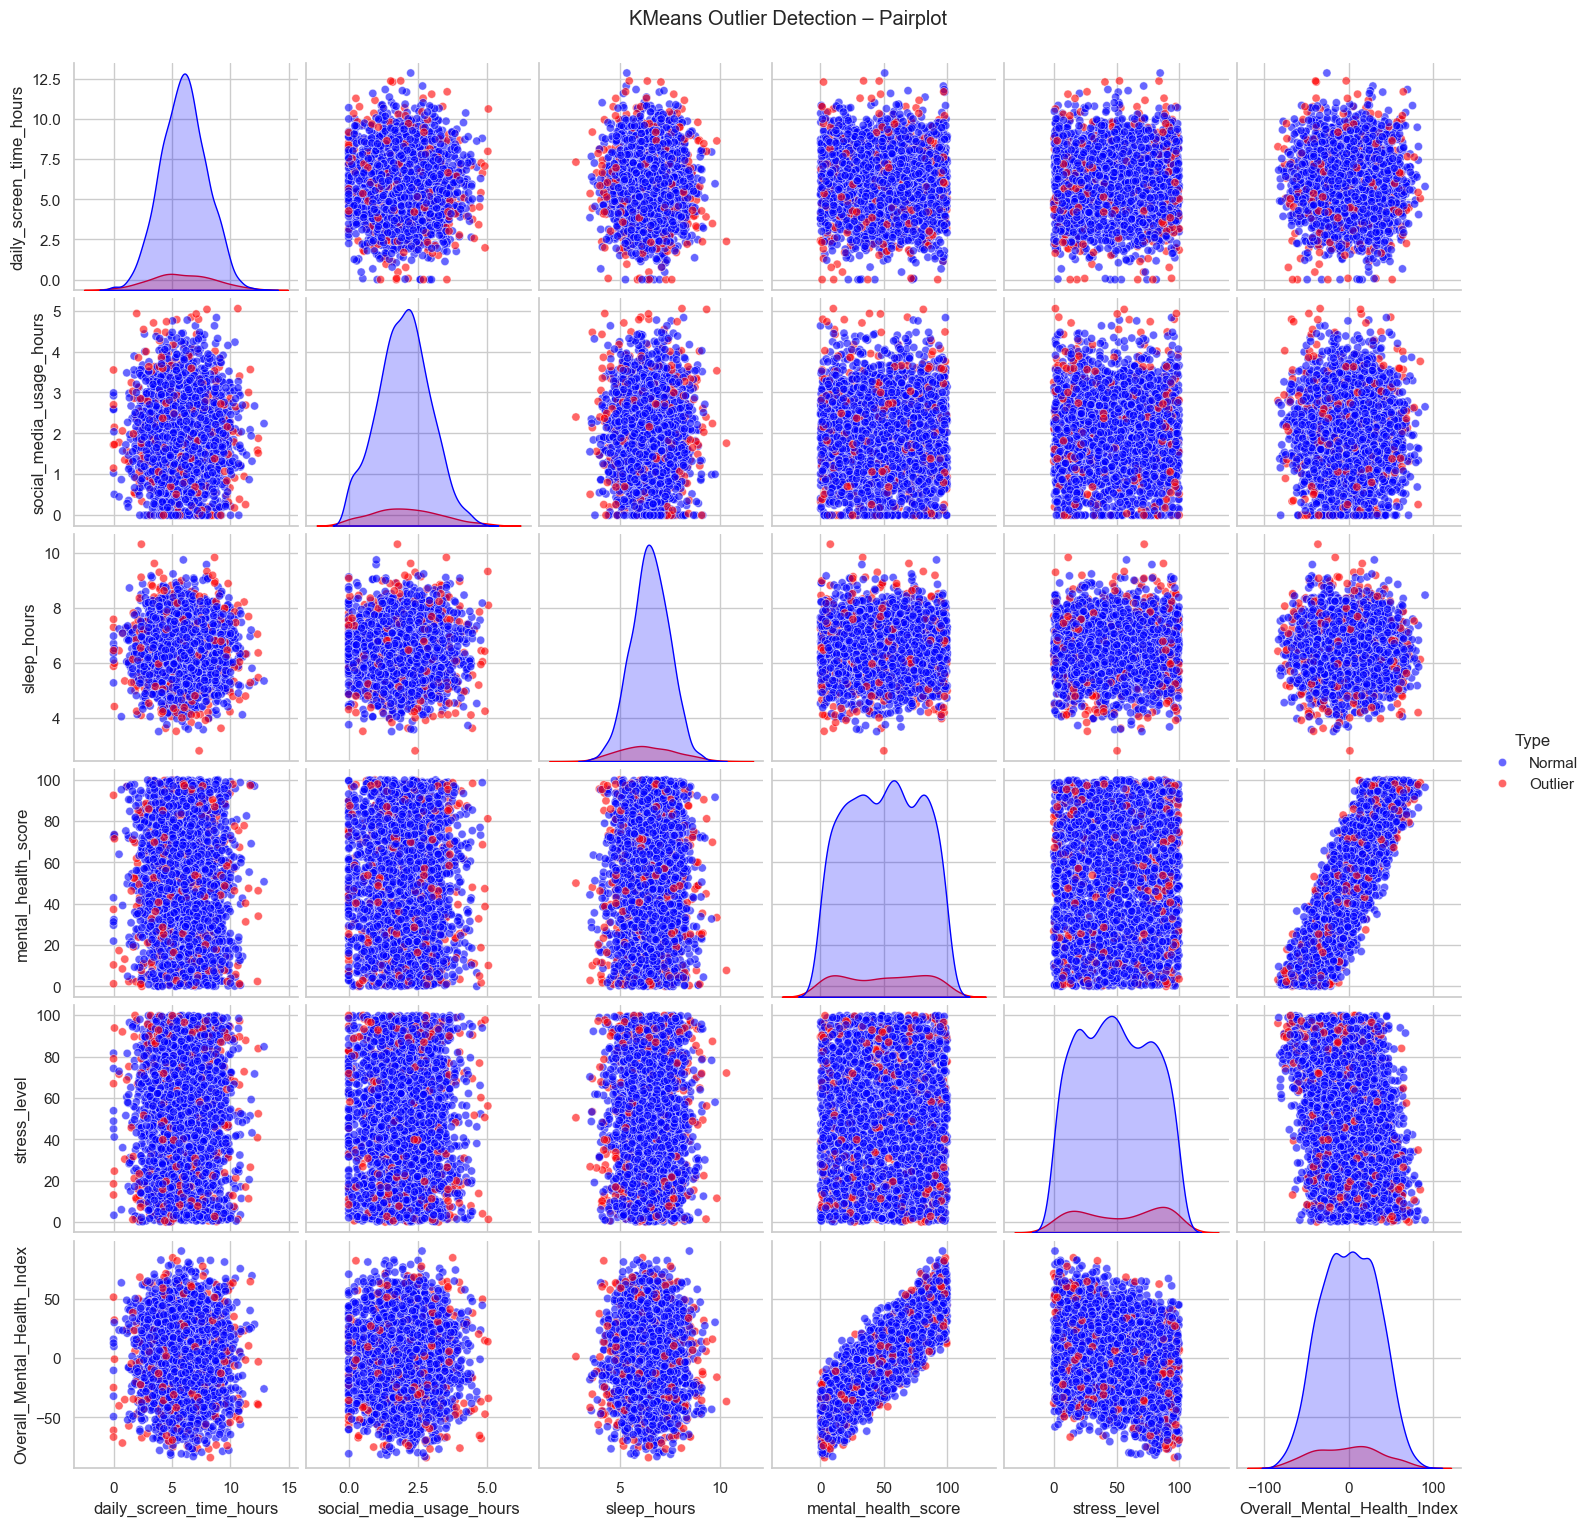

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

features = df[numerical_columns]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)

distances = kmeans.transform(scaled_features)
min_distance = np.min(distances, axis=1)

threshold = np.percentile(min_distance, 90)
df['Outlier'] = min_distance > threshold

df['Type'] = df['Outlier'].apply(lambda x: 'Outlier' if x else 'Normal')

plot_columns = [
    'daily_screen_time_hours',
    'social_media_usage_hours',
    'sleep_hours',
    'mental_health_score',
    'stress_level',
    'Overall_Mental_Health_Index'
]

pairplot = sns.pairplot(
    df,
    vars=plot_columns,
    hue='Type',
    palette={'Normal': 'blue', 'Outlier': 'red'},
    plot_kws={'alpha': 0.6, 's': 35},
    diag_kind='kde',
    diag_kws={'fill': True}
)

pairplot.fig.suptitle('KMeans Outlier Detection – Pairplot', y=1.02)
plt.show()


Total rows: 2986
Outliers detected: 85
Rows after removal: 2901


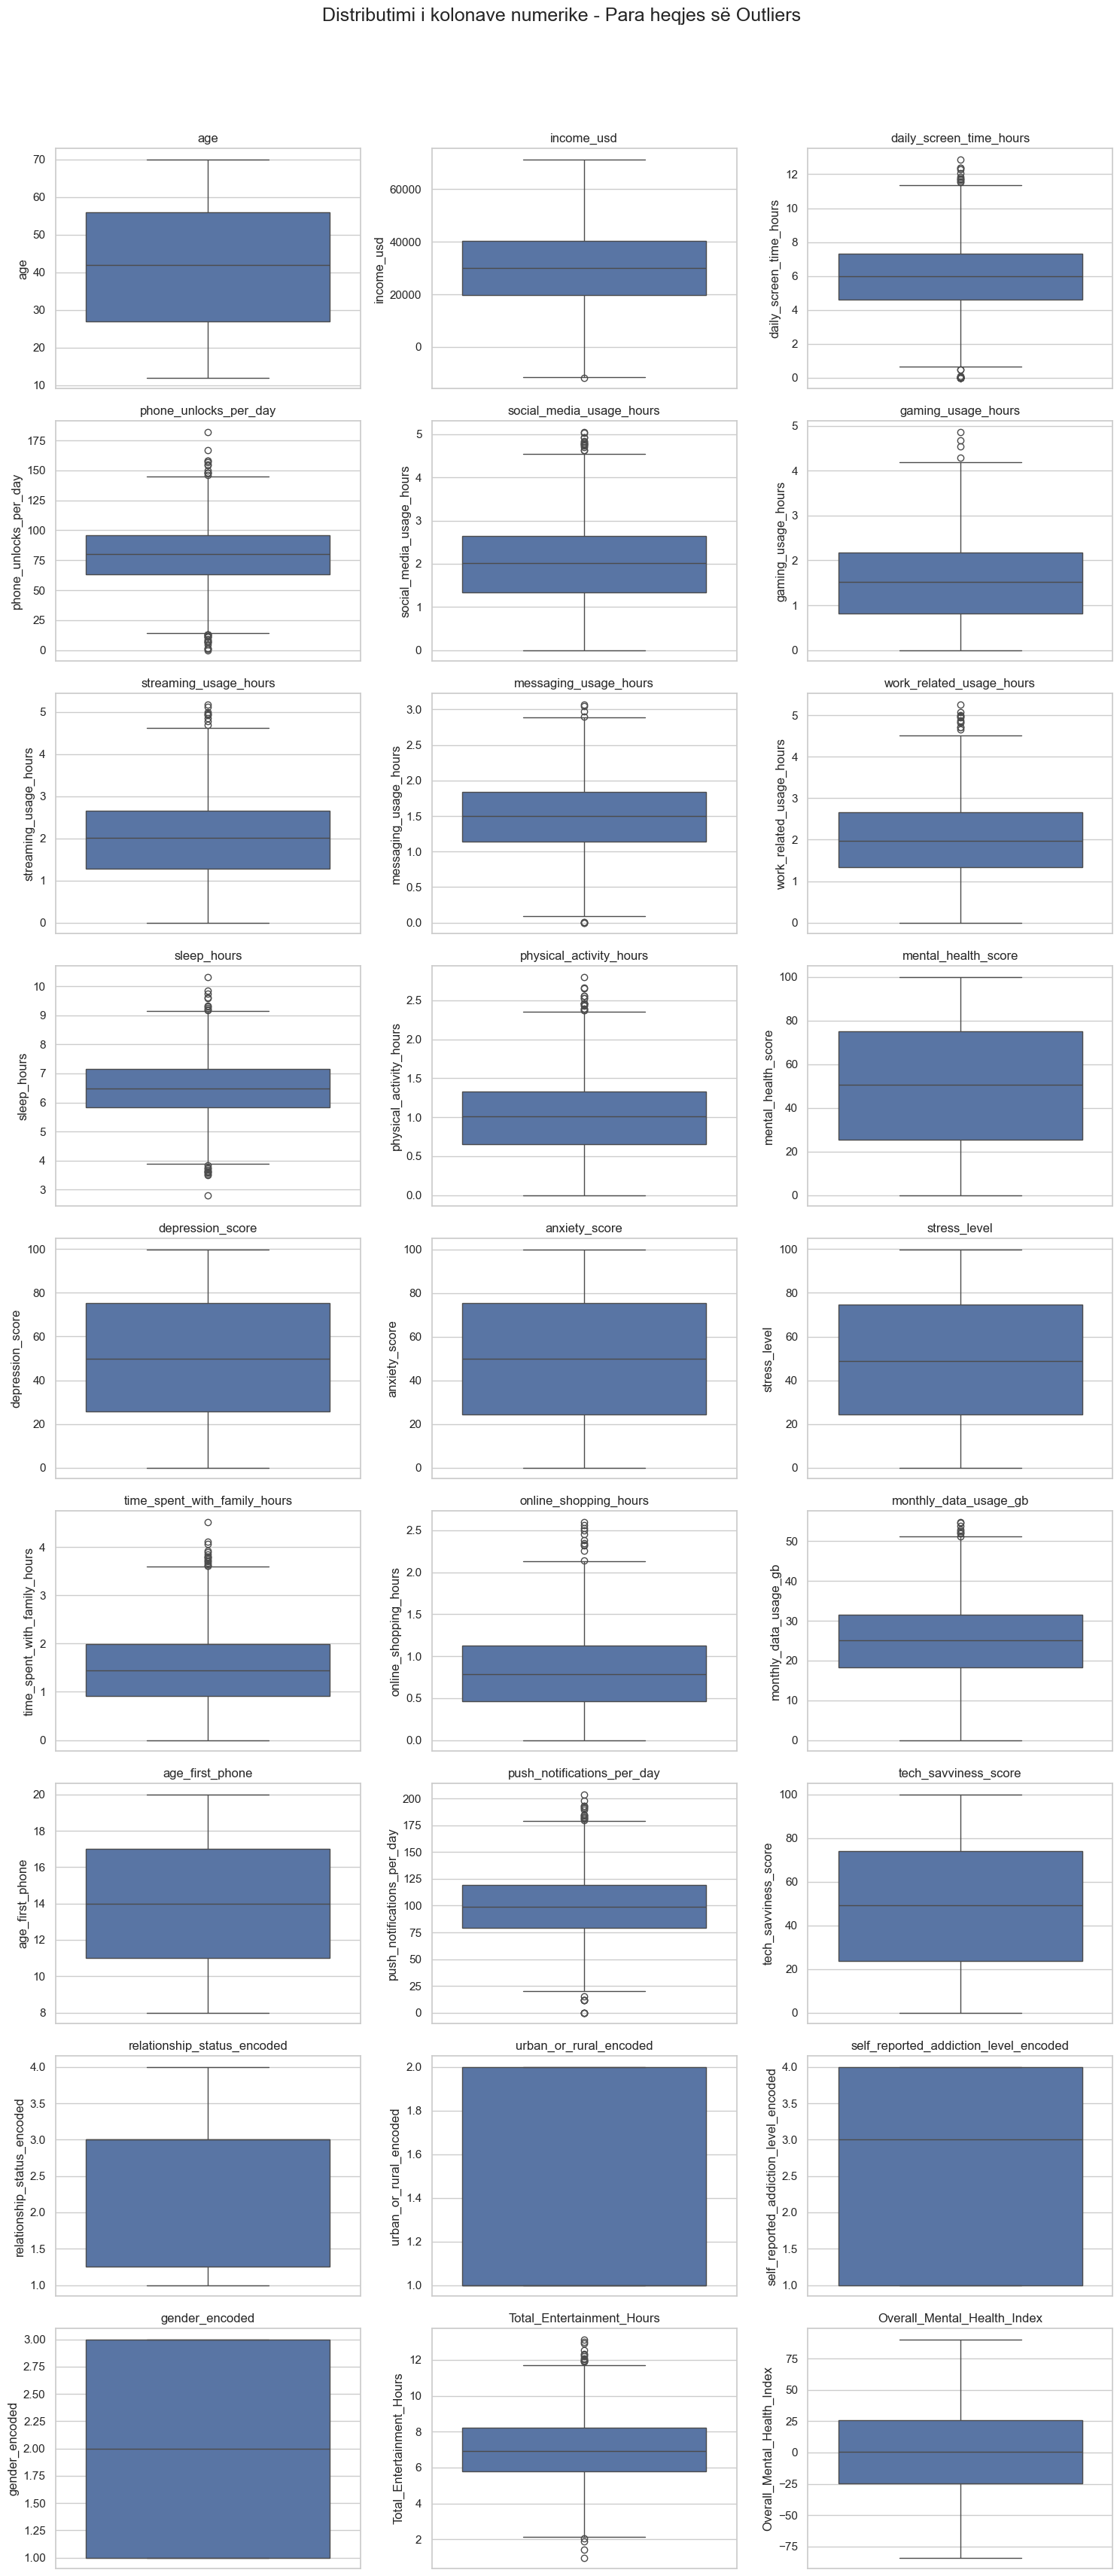

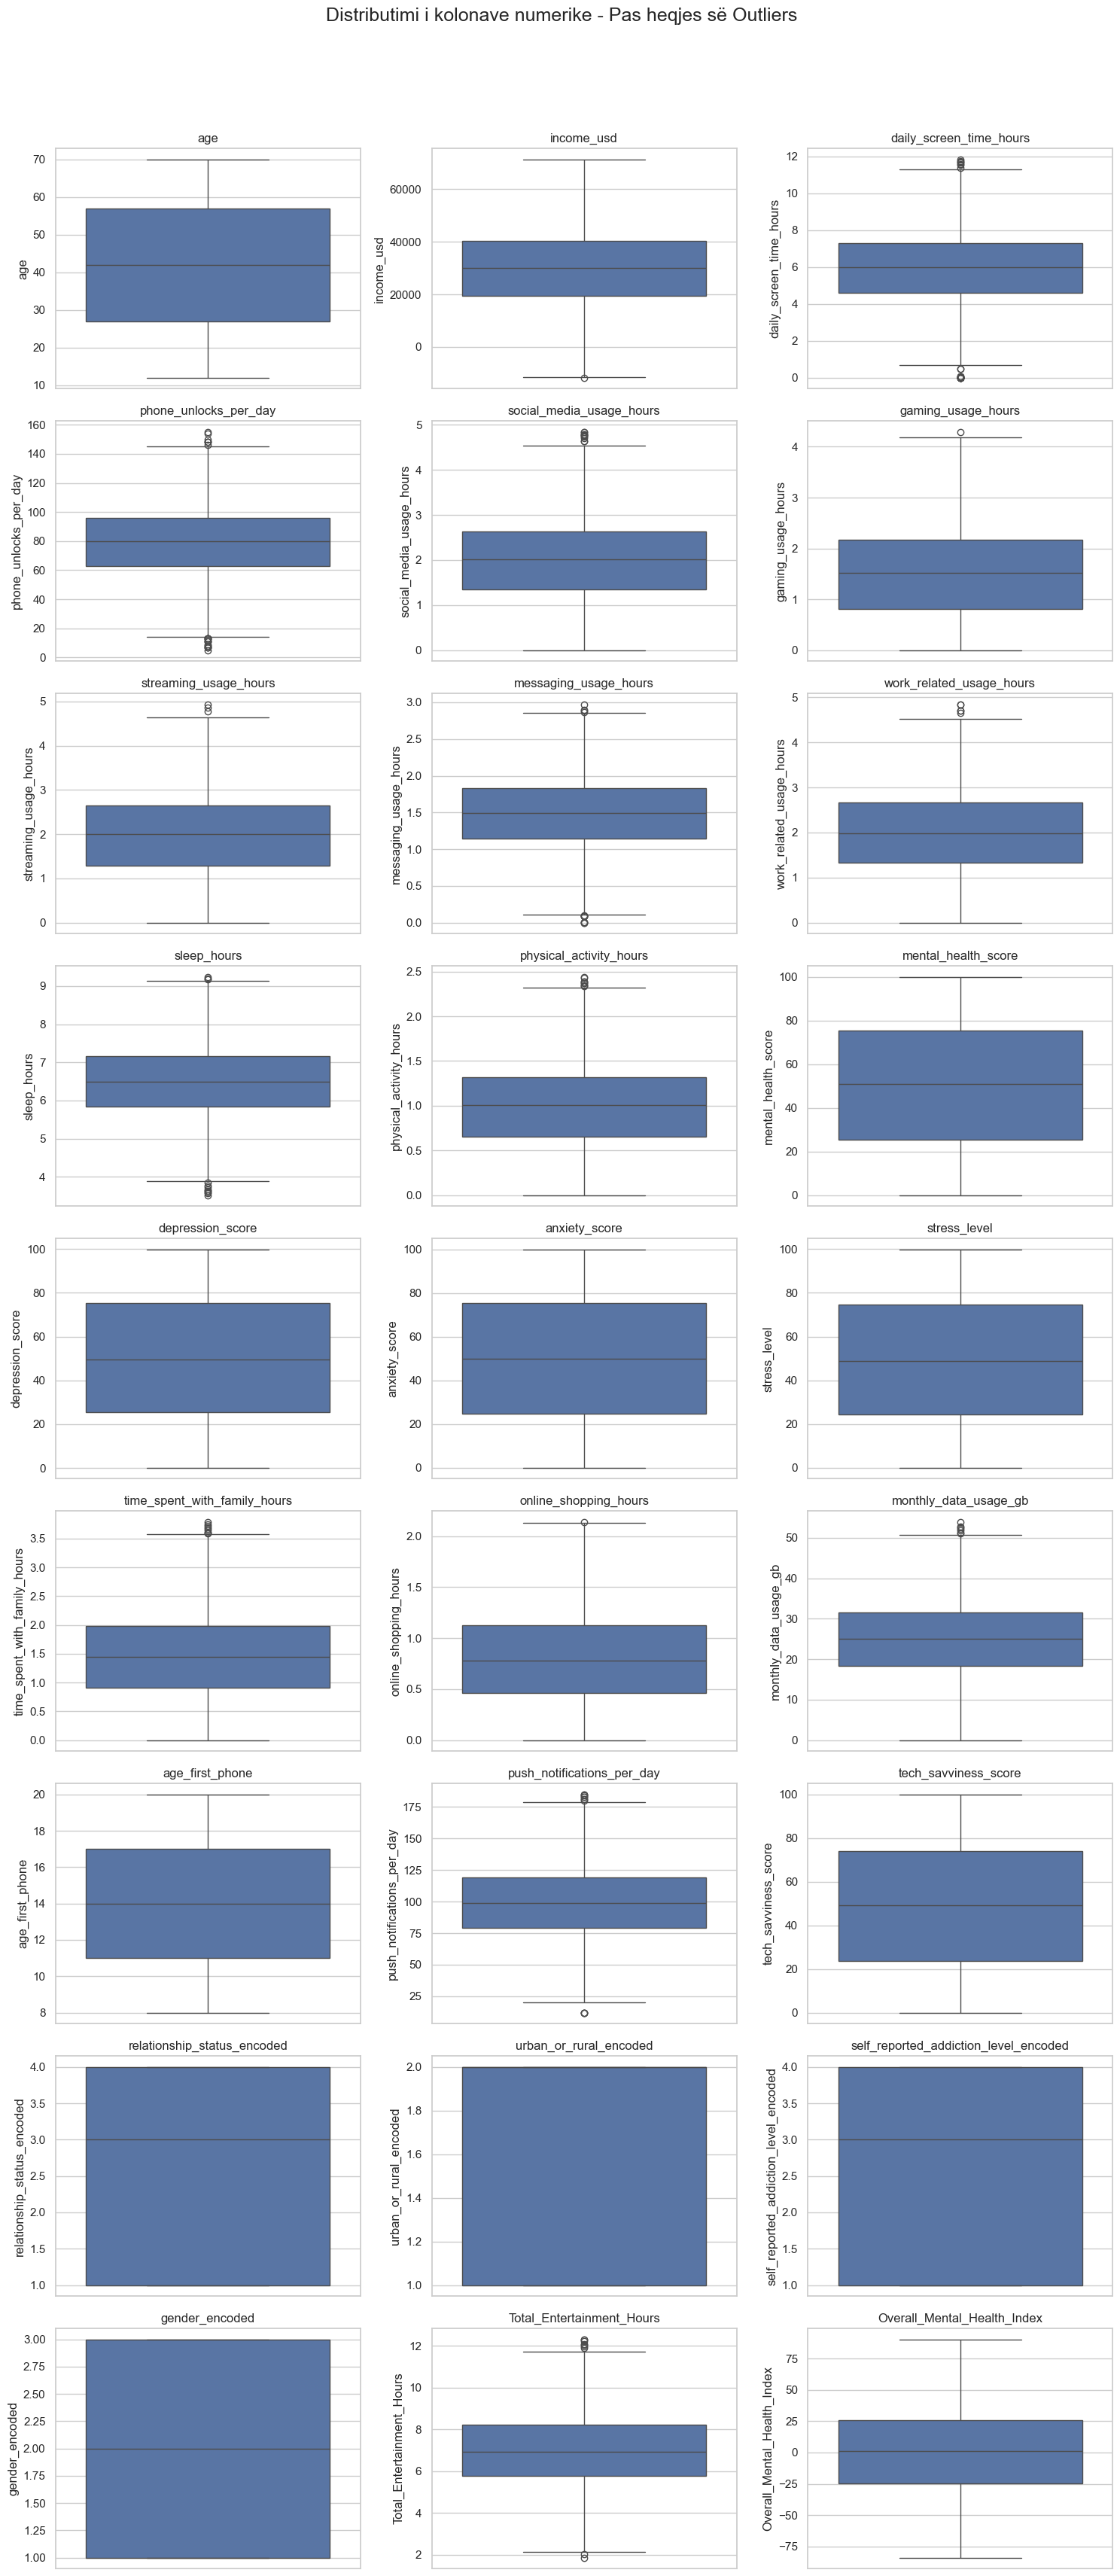

In [35]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


data_numeric = df[numerical_columns]

z_scores = np.abs(stats.zscore(data_numeric, nan_policy='omit'))

threshold = 3

outliers_mask = (z_scores > threshold).any(axis=1)

print("Total rows:", len(df))
print("Outliers detected:", outliers_mask.sum())
print("Rows after removal:", len(df) - outliers_mask.sum())

df_clean = df[~outliers_mask].reset_index(drop=True)

sns.set_theme(style="whitegrid")

def plot_boxplots(data, title):
    n_cols = 3
    n_rows = int(np.ceil(len(numerical_columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_boxplots(df, "Distributimi i kolonave numerike - Para heqjes së Outliers")

plot_boxplots(df_clean, "Distributimi i kolonave numerike - Pas heqjes së Outliers")

df_outliers = df[outliers_mask]


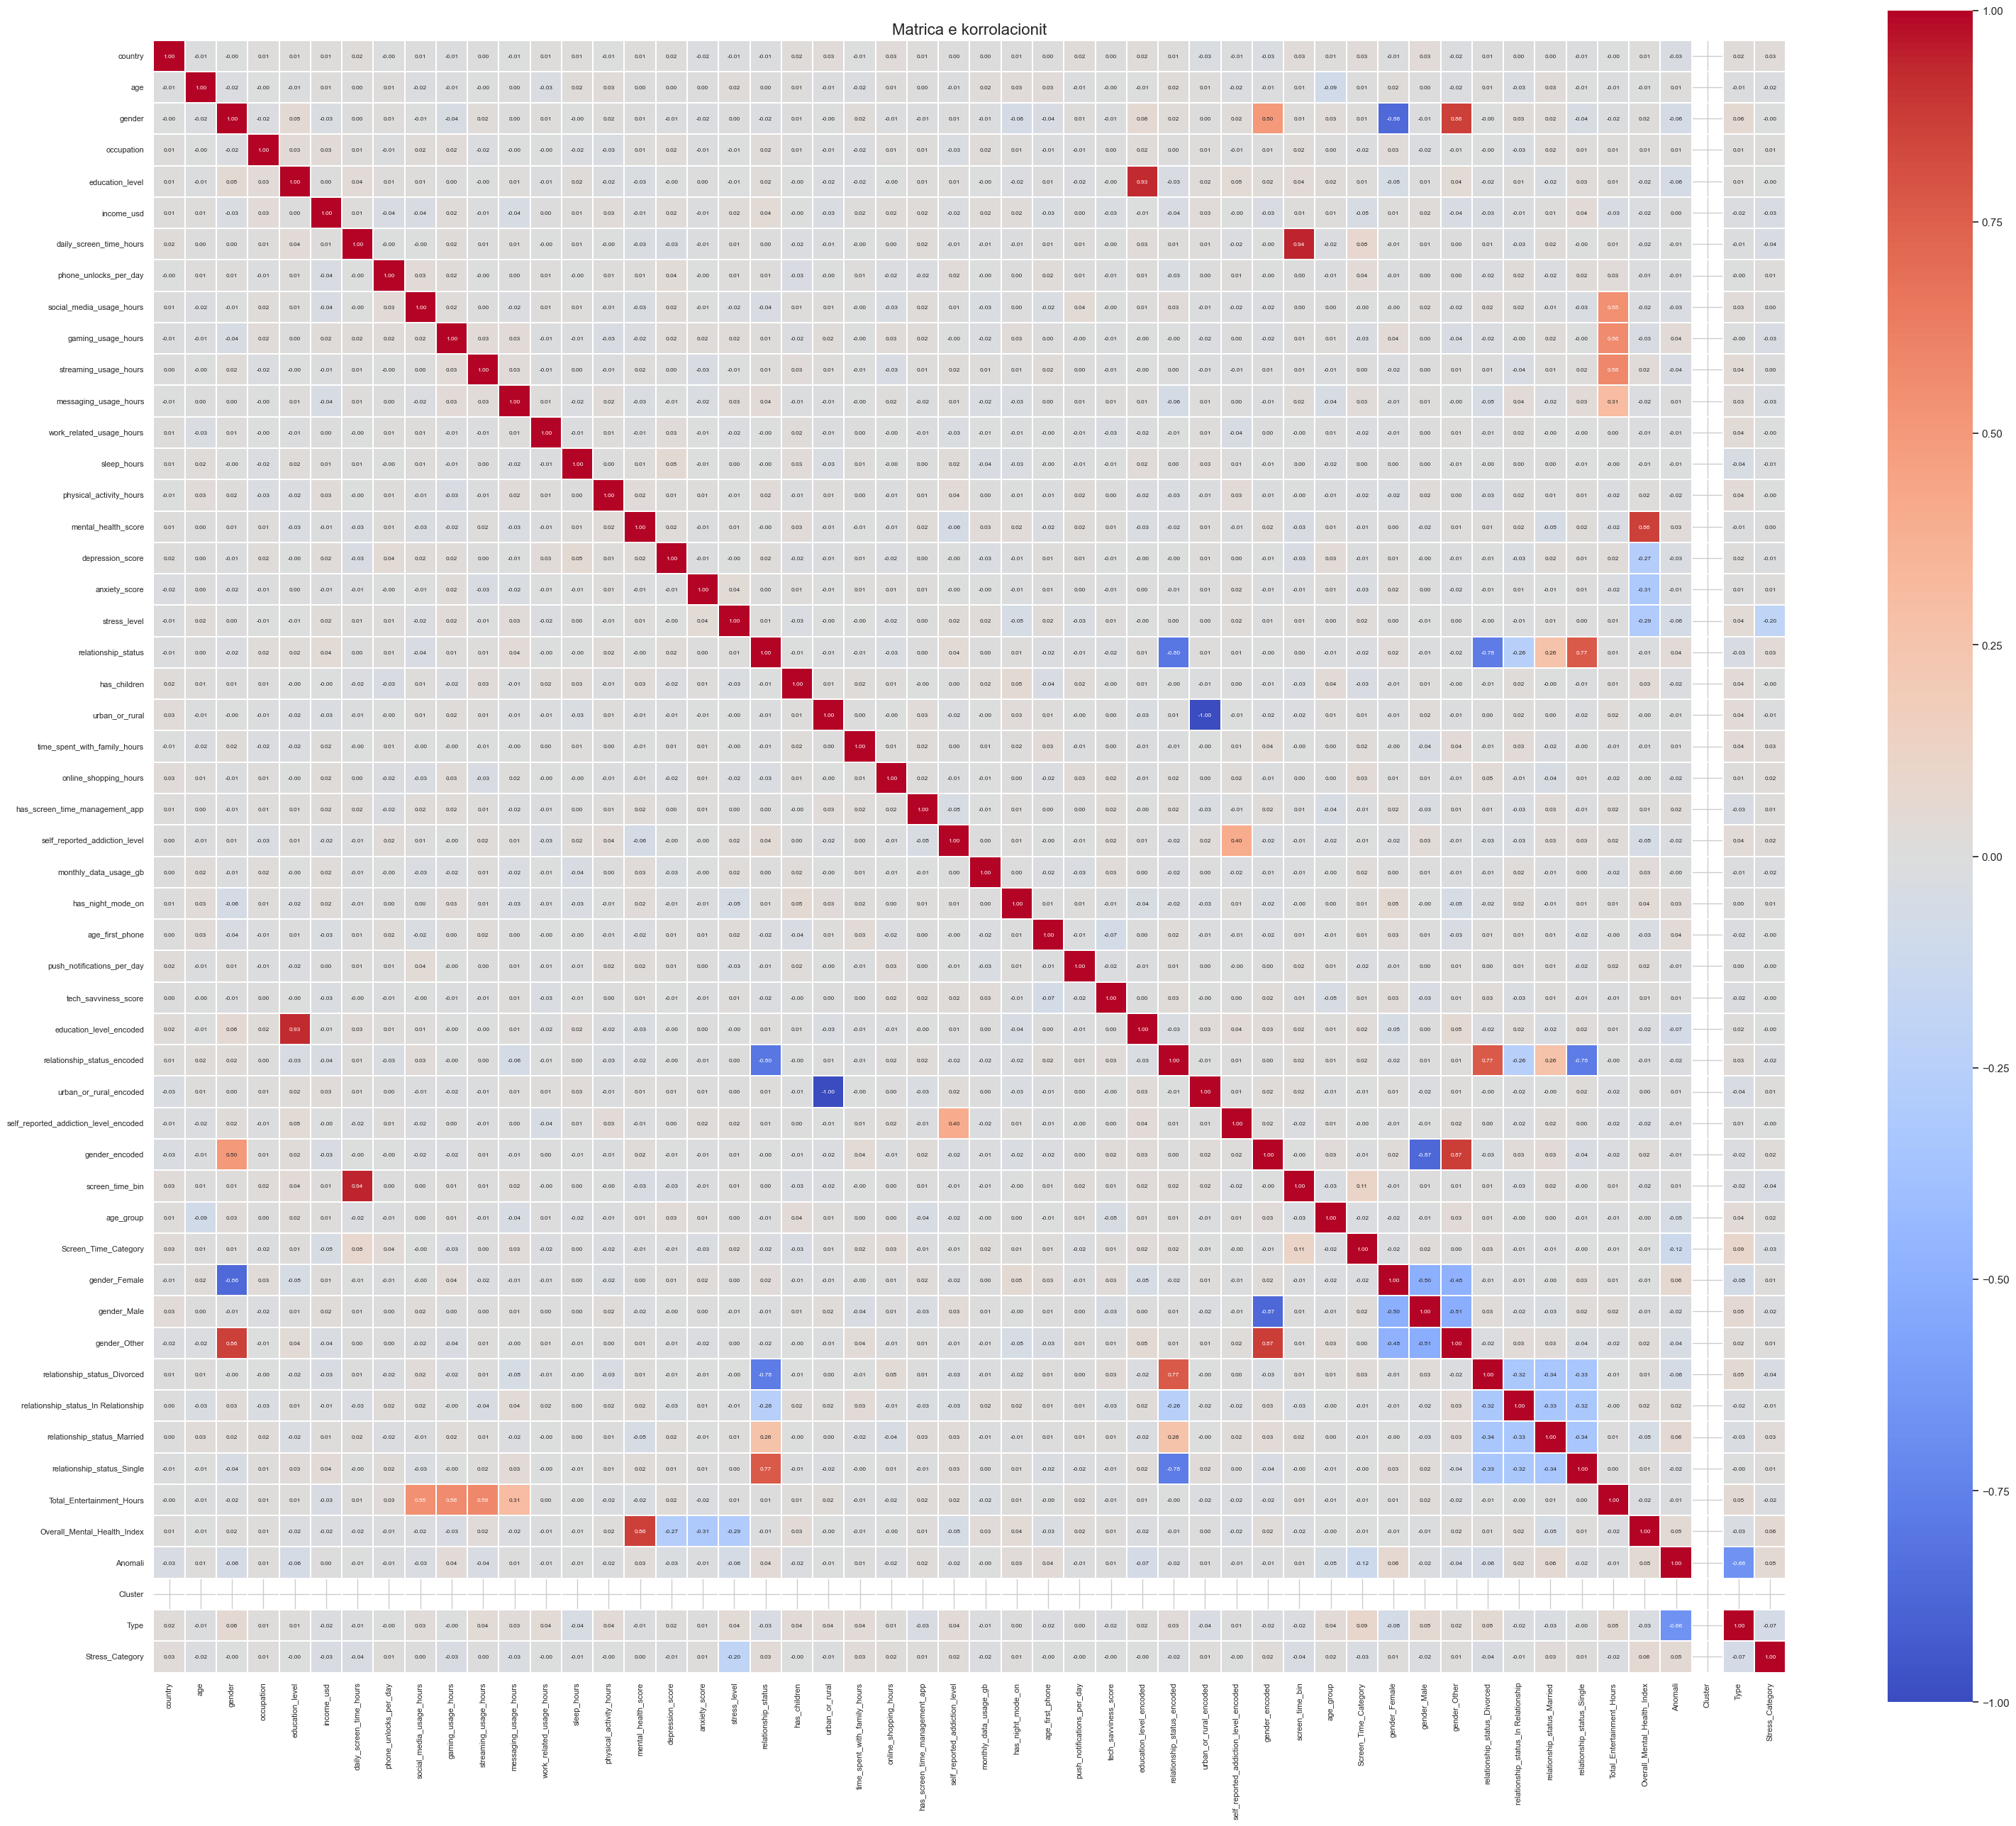

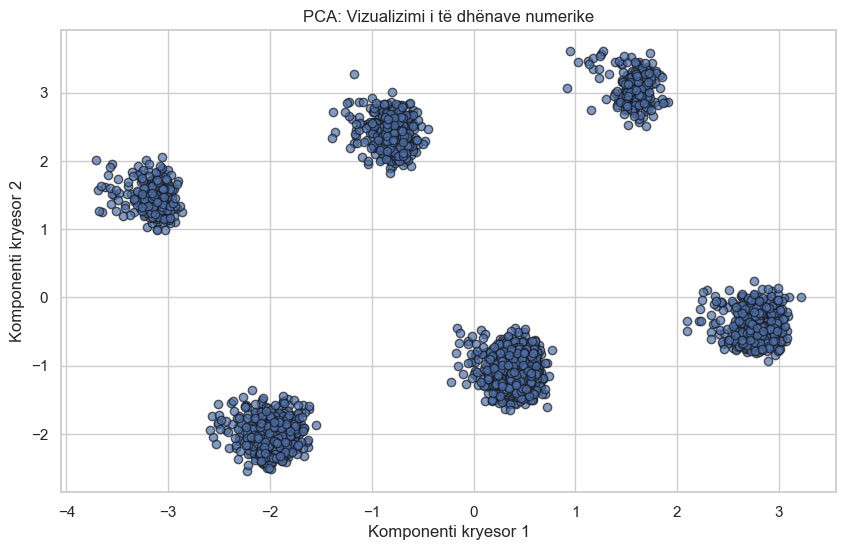


Shpërndarja e frekuencës së të dhënave kategorike (në përqindje):

Kolona: is_rural
is_rural
False    50.167448
True     49.832552
Name: proportion, dtype: float64


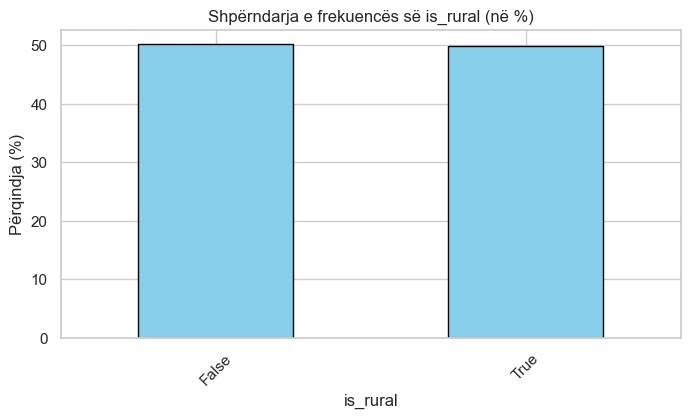


Kolona: is_urban
is_urban
True     50.167448
False    49.832552
Name: proportion, dtype: float64


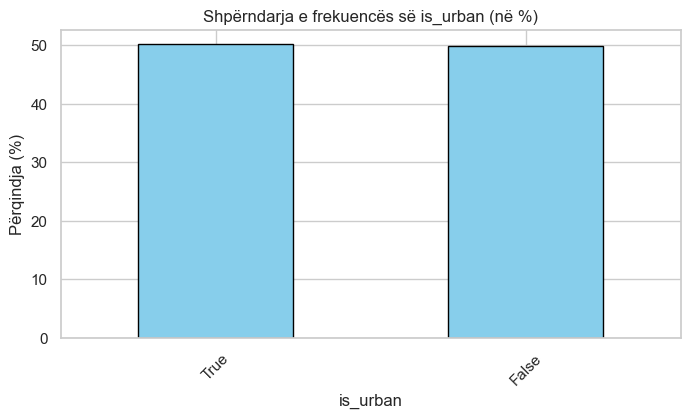


Kolona: has_children_0
has_children_0
False    50.133958
True     49.866042
Name: proportion, dtype: float64


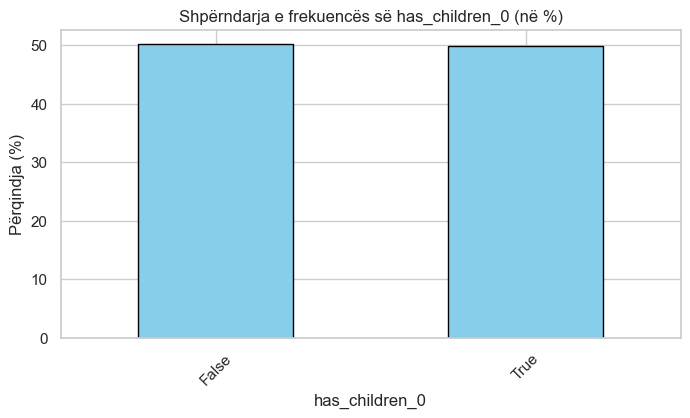


Kolona: has_children_1
has_children_1
True     50.133958
False    49.866042
Name: proportion, dtype: float64


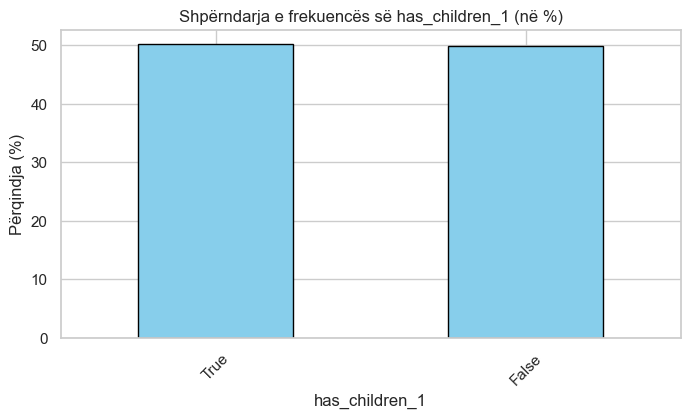


Kolona: Outlier
Outlier
False    89.986604
True     10.013396
Name: proportion, dtype: float64


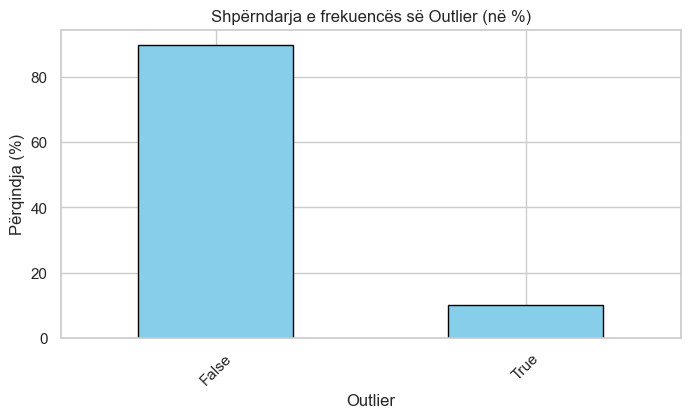


Kolona: Stress_Result
Stress_Result
Low     67.950435
High    32.049565
Name: proportion, dtype: float64


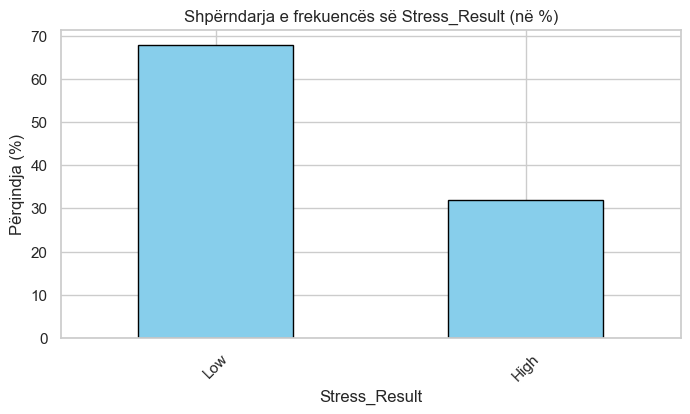

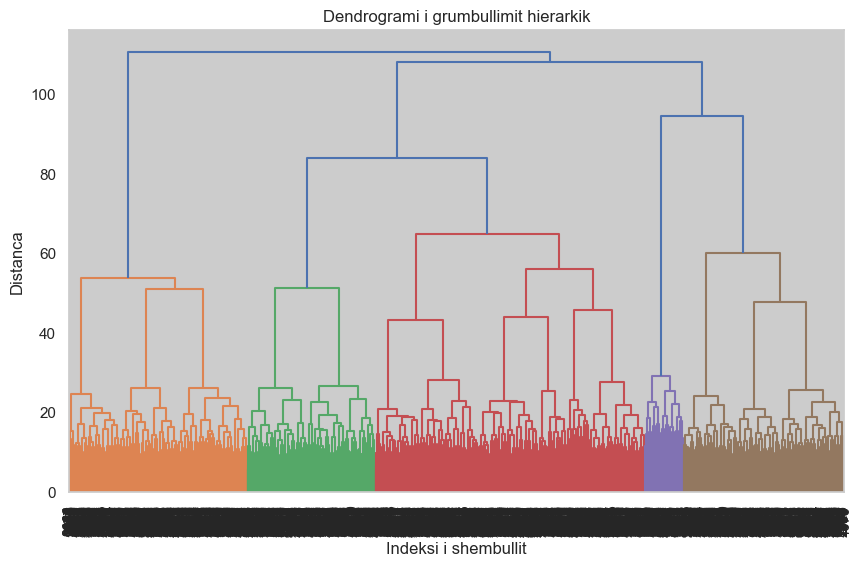

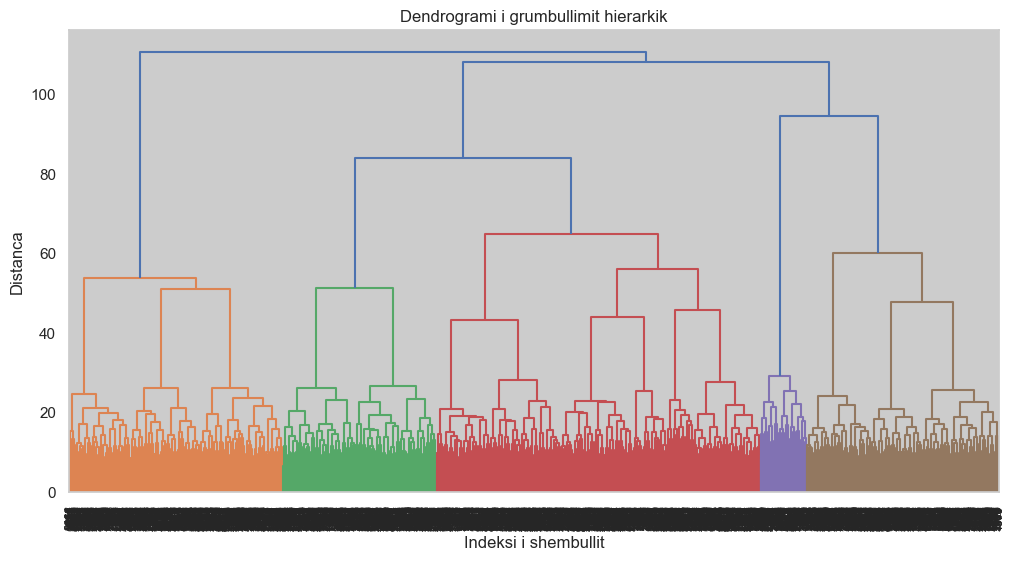


Statistikat përmbledhëse për të dhënat Numerike:
                                        count          mean           std  \
country                                2986.0      4.573342      2.872526   
age                                    2986.0     41.318486     17.057653   
gender                                 2986.0      1.008707      0.806542   
occupation                             2986.0      3.507703      2.319701   
education_level                        2986.0      1.401206      1.004071   
income_usd                             2986.0  29876.619066  15075.840248   
daily_screen_time_hours                2986.0      5.984012      2.018028   
phone_unlocks_per_day                  2986.0     79.696919     25.134910   
social_media_usage_hours               2986.0      1.997405      0.963884   
gaming_usage_hours                     2986.0      1.519357      0.935469   
streaming_usage_hours                  2986.0      1.989786      0.981379   
messaging_usage_hours     

In [56]:
numeric_data = df.select_dtypes(include=['number'])
categorical_data = df.select_dtypes(exclude=['number'])
corr = numeric_data.corr()
correlation_matrix = numeric_data.corr()

# Auto-scale figure size based on columns
num_cols = len(corr.columns)
plt.figure(figsize=(num_cols * 0.6, num_cols * 0.5))

sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.3,
    annot_kws={"size": 6}  # smaller font for numbers
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.title("Matrica e korrolacionit", fontsize=16)

plt.tight_layout()
plt.show()

# b. PCA për vizualizim
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data.fillna(0))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolor='k')
plt.title("PCA: Vizualizimi i të dhënave numerike")
plt.xlabel("Komponenti kryesor 1")
plt.ylabel("Komponenti kryesor 2")
plt.show()

# 2. Analiza e të dhënave kategorike
# a. Shpërndarja e frekuencës
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data.fillna(0))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

print("\nShpërndarja e frekuencës së të dhënave kategorike (në përqindje):")
for col in categorical_data.columns:
    print(f"\nKolona: {col}")
    
    # Përqindjet për secilën kategori
    freq_percent = categorical_data[col].value_counts(normalize=True) * 100
    print(freq_percent)
    
    # Vizualizimi i shpërndarjes së frekuencës
    freq_percent.plot(kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black')
    plt.title(f"Shpërndarja e frekuencës së {col} (në %)")
    plt.xlabel(col)
    plt.ylabel("Përqindja (%)")
    plt.xticks(rotation=45)
    plt.show()


# 3. Analiza e grumbullimit (clustering)
# Grumbullimi hierarkik
linkage_matrix = linkage(scaled_data, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=10.)
plt.title("Dendrogrami i grumbullimit hierarkik")
plt.xlabel("Indeksi i shembullit")
plt.ylabel("Distanca")
plt.show()
# ----------------------------------------------------
# 3. Analiza e grumbullimit (Hierarchical Clustering)
# ----------------------------------------------------
linkage_matrix = linkage(scaled_data, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=8.)
plt.title("Dendrogrami i grumbullimit hierarkik")
plt.xlabel("Indeksi i shembullit")
plt.ylabel("Distanca")
plt.show()

# ----------------------------------------------------
# 4. Statistikat përmbledhëse për të dhënat numerike
# ----------------------------------------------------
print("\nStatistikat përmbledhëse për të dhënat Numerike:")
print(numeric_data.describe().transpose())

#Skewness

c:\Users\Rinor\Faculty\PVDH\Projekti\PVDH-G10\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2065: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


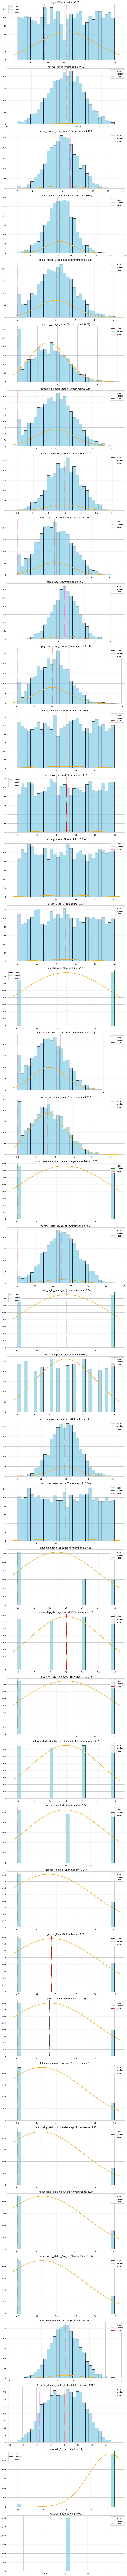

In [39]:
numeric_data = df.select_dtypes(include=['number'])

skewness = numeric_data.skew()

fig, axes = plt.subplots(
    nrows=len(numeric_data.columns), 
    ncols=1, 
    figsize=(10, 5 * len(numeric_data.columns))
)

if len(numeric_data.columns) == 1:
    axes = [axes]

for ax, column in zip(axes, numeric_data.columns):

    # Filtro vlerat jo-finite
    data = numeric_data[column].replace([np.inf, -np.inf], np.nan).dropna()

    if len(data) == 0:   # në rast se kolona është bosh
        ax.set_title(f"{column} — SKIP (nuk ka vlera të vlefshme)")
        continue

    mode_values = data.mode()

    # Histogrami
    data.hist(ax=ax, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    # Fit i shpërndarjes normale
    mu, std = norm.fit(data)

    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    # skalim që lakorja të shfaqet sipër histogramit
    ax.plot(x, p * max(data.value_counts()) / max(p), 'orange', linewidth=2)

    # Titra & statistika
    ax.set_title(f"{column} (Shtrembërimi: {skewness[column]:.2f})", fontsize=14)
    ax.axvline(mode_values[0], color='purple', linestyle='dashed', linewidth=1, label="Mode")
    ax.axvline(data.median(), color='green', linestyle='dashed', linewidth=1, label="Median")
    ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=1, label="Mean")

    ax.legend()

plt.tight_layout()
plt.show()


#SMOTE

Shpërndarja e klasës para algoritmit SMOTE:
Stress_Category
1    1806
2     611
0     569
Name: count, dtype: int64

Shpërndarja e klasës pas algoritmit SMOTE:
Stress_Category
0    1806
1    1806
2    1806
Name: count, dtype: int64


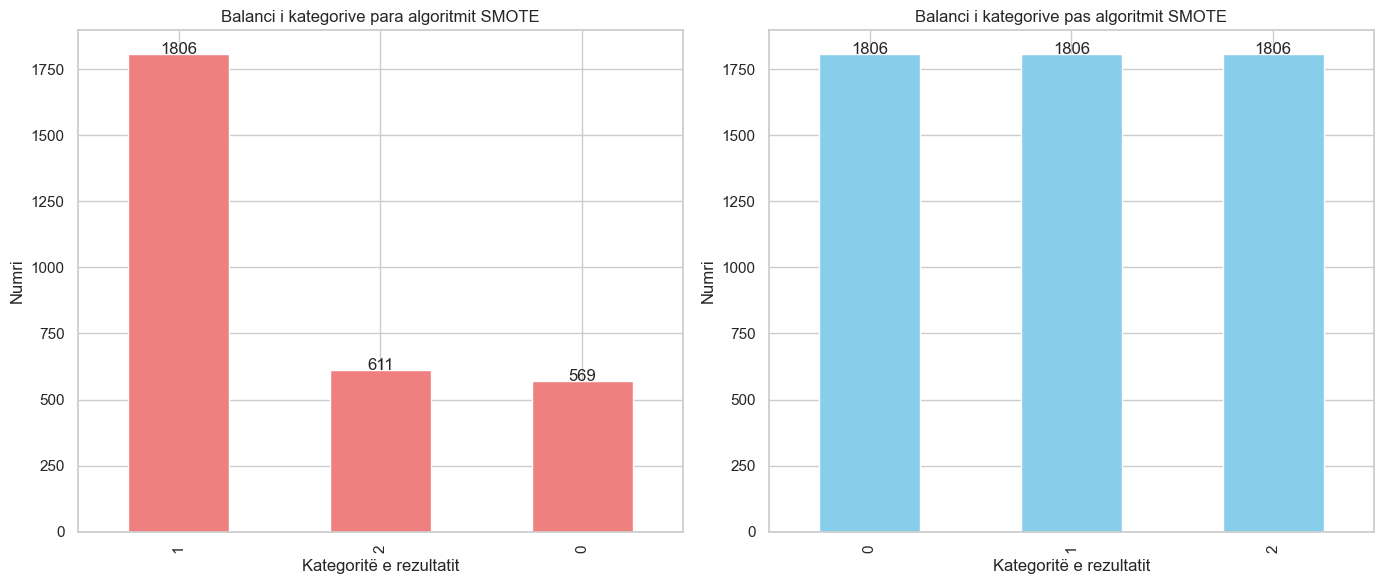

In [49]:
df['Stress_Category'] = pd.cut(df['stress_level'], bins=[0, 59, 80, 100], labels=['Low', 'Medium', 'High'])

# Identifikimi i kolonave kategorike dhe numerike
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plotësimi i vlerave të munguar për kolonat kategorike me modën
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Plotësimi i vlerave të munguar për kolonat numerike me medianën
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Kodimi i variablave kategorike duke përdorur Label Encoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Definimi i veçorive dhe objektivit
X = df.drop(['stress_level', 'Stress_Category'], axis=1)
y = df['Stress_Category']

# Kontrollimi i balancës para aplikimit të SMOTE
class_counts_before = y.value_counts()
print("Shpërndarja e klasës para algoritmit SMOTE:")
print(class_counts_before)

# Aplikimi i SMOTE për të balancuar datasetin
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Kontrollimi i balancës pas aplikimit të SMOTE
class_counts_after = pd.Series(y_resampled).value_counts()
print("\nShpërndarja e klasës pas algoritmit SMOTE:")
print(class_counts_after)

# Shfaqja e balancës para dhe pas aplikimit të SMOTE
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Para SMOTE
class_counts_before.plot(kind='bar', color='lightcoral', ax=ax[0])
ax[0].set_title('Balanci i kategorive para algoritmit SMOTE')
ax[0].set_xlabel('Kategoritë e rezultatit')
ax[0].set_ylabel('Numri')
for i, v in enumerate(class_counts_before):
    ax[0].text(i, v + 1, str(v), ha='center')

# Pas SMOTE
class_counts_after.plot(kind='bar', color='skyblue', ax=ax[1])
ax[1].set_title('Balanci i kategorive pas algoritmit SMOTE')
ax[1].set_xlabel('Kategoritë e rezultatit')
ax[1].set_ylabel('Numri')
for i, v in enumerate(class_counts_after):
    ax[1].text(i, v + 1, str(v), ha='center')

plt.tight_layout()
plt.show()

In [53]:
df.to_csv('dataset/mobile_addiction_data_processed2.csv', index=False)